In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [2]:
liar_data = pd.read_csv('train (1).csv', names=["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pantson fire","context"])

In [3]:
liar_data['label'] = liar_data['label'].replace({
    'pants-fire': 0,
    'FALSE': 0,
    'barely-true': 0,
    'half-true': 1,
    'mostly-true': 1,
    'TRUE': 1
})

In [4]:
# Select only the relevant columns for our task
liar_data = liar_data[['statement', 'label']]

In [5]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(liar_data, test_size=0.2, random_state=42)

In [6]:
# Tokenize the statements using Keras' Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['statement'])

In [7]:
# Convert the tokenized sequences to padded sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['statement']), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['statement']), maxlen=100)

In [8]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(5000, 64))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [9]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, train_data['label'], batch_size=64, epochs=50, validation_split=0.1, callbacks=[early_stop])

Epoch 1/50
116/116 [==============================] - 25s 191ms/step - loss: 0.8207 - accuracy: 0.5218 - val_loss: 0.6942 - val_accuracy: 0.4378
Epoch 2/50
116/116 [==============================] - 25s 213ms/step - loss: 0.7015 - accuracy: 0.5345 - val_loss: 0.6808 - val_accuracy: 0.5829
Epoch 3/50
116/116 [==============================] - 24s 204ms/step - loss: 0.6898 - accuracy: 0.5541 - val_loss: 0.6816 - val_accuracy: 0.5793
Epoch 4/50
116/116 [==============================] - 23s 199ms/step - loss: 0.6516 - accuracy: 0.6259 - val_loss: 0.7023 - val_accuracy: 0.5878
Epoch 5/50
116/116 [==============================] - 32s 277ms/step - loss: 0.5880 - accuracy: 0.7060 - val_loss: 0.7382 - val_accuracy: 0.5354


In [11]:
# Evaluate the model on the test set
score, acc = model.evaluate(X_test, test_data['label'], batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

32/32 [==============================] - 3s 79ms/step - loss: 0.7313 - accuracy: 0.5439
Test score: 0.7313091158866882
Test accuracy: 0.5439453125


In [12]:
# Make predictions on the test set and calculate evaluation metrics
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

64/64 [==============================] - 4s 28ms/step


In [13]:
print(test_data['label'].shape)
print(y_pred.shape)

(2048,)
(2048, 6)


In [14]:
print(classification_report(test_data['label'], y_pred_labels))

              precision    recall  f1-score   support

           0       0.48      0.72      0.58       888
           1       0.66      0.41      0.50      1160

    accuracy                           0.54      2048
   macro avg       0.57      0.56      0.54      2048
weighted avg       0.58      0.54      0.54      2048



Confusion Matrix:
[[640 248]
 [686 474]]


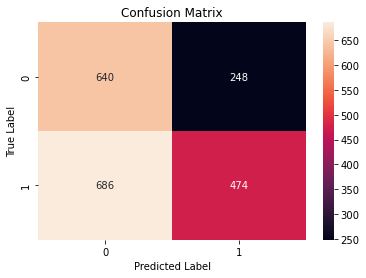

In [15]:
cm = confusion_matrix(test_data['label'], y_pred_labels)
print(f'Confusion Matrix:\n{cm}')
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

AUC: 0.565


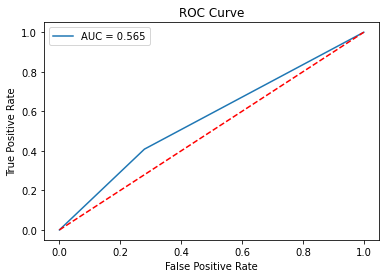

In [16]:
fpr, tpr, thresholds = roc_curve(test_data['label'], y_pred_labels)
auc = roc_auc_score(test_data['label'], y_pred_labels)
print(f'AUC: {auc:.3f}')
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()